In [128]:
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import openpyxl
from openpyxl import load_workbook
import pandas as pd
import math
import seaborn as sns 
import umap
import umap.plot
from PIL import Image
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
randomstate = 42
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, PandasTools, Descriptors, Draw, PropertyMol, rdmolfiles, rdFMCS
from rdkit import RDConfig
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions, Font
DrawingOptions.bondLineWidth=1.8
size = (150, 150)
import plotly.express as px
import molplotly # requires dash version 2.0 (latest = 2.1); use pip list and pip install dash==2.0
import mols2grid
from tdc.single_pred import ADME
import useful_rdkit_utils as uru
from tqdm import tqdm
from IPython.display import SVG
import mordred
from mordred import Calculator, descriptors

# Assemble the molecules

A molecular core bearing a bromide and a carboxylic acid was chosen as an example. The acid will be used to make amides with 10 different amines, and the bromide will be used to add 15 aryl boronic acids.

*References*

It is also possible to fragment a set of compounds ("R-group decomposition"), then reassenble all the possible structures: https://greglandrum.github.io/rdkit-blog/tutorial/rgd/2022/03/14/rgd-and-molzip.html

https://greglandrum.github.io/rdkit-blog/tutorial/substructure/2021/08/03/generalized-substructure-search.html#Bring-it-all-together

https://greglandrum.github.io/rdkit-blog/tutorial/substructure/2021/05/13/intro-to-the-molecule-enumerator.html

https://greglandrum.github.io/rdkit-blog/tutorial/prototypes/drawing/2021/08/07/rgd-and-highlighting.html

**Define the core**

Build the core in chemdraw and copy the smiles here. The functional groups to be altered are replaced with dummy atoms.

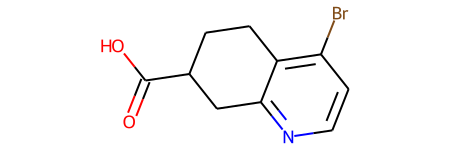

In [129]:
core_1 = Chem.MolFromSmiles('OC(C1CCC2=C(Br)C=CN=C2C1)=O')
core_1

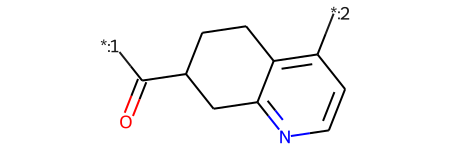

In [130]:
match = Chem.MolFromSmarts('[OH]')
repl = Chem.MolFromSmarts('[*:1]')
core_2 = Chem.ReplaceSubstructs(core_1, match, repl)
core_3=core_2[0]

match = Chem.MolFromSmarts('[Br]')
repl = Chem.MolFromSmarts('[*:2]')
core_4 = Chem.ReplaceSubstructs(core_3, match, repl)
core_5=core_4[0]
core_5

**Define the first fragment: 10 primary/secondary amines**

Read in SMILES from an excel file and drop duplicates.

In [131]:
amines = pd.read_excel('amines.xlsx',engine='openpyxl')
print('Number of amines:',len(amines))

amines = amines.drop_duplicates(subset=['amines'])                         # drop duplicates based on smiles

amines['rdmol'] = amines['amines'].map(lambda x: Chem.MolFromSmiles(x))    # drop duplicates based on inchi
amines['inchi'] = amines['rdmol'].map(Chem.MolToInchi)
amines = amines.drop_duplicates(subset="inchi")

print('Number of amines after duplicates removed:',len(amines))

#amines

Number of amines: 10
Number of amines after duplicates removed: 10


Replace one of the hydrogen atoms attached to the nitrogen with a dummy atom labeled 1.

*Added try except but haven't encountered any errors. If the molecule doesn't have the substructure for replacement then it just gives back the original molecule unchanged.*

In [132]:
def dummify(mol):
    try:
        mol_with_H = Chem.AddHs(mol)
        match = Chem.MolFromSmarts('[N][H]')
        repl = Chem.MolFromSmarts('[N][*:1]')
        amine_dummy = Chem.ReplaceSubstructs(mol_with_H, match, repl)
        amine_dummy=amine_dummy[0]
        return amine_dummy
    except:
        return 'NaN'

amines['mol_dummy'] = amines.rdmol.map(dummify)
amines['smiles_dummy'] = amines['mol_dummy'].map(Chem.MolToSmiles)

amines

,amines,rdmol,inchi,mol_dummy,smiles_dummy
0,NCC,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C2H7N/c1-2-3/h2-3H2,1H3","<img data-content=""rdkit/molecule"" src=""data:i...",[H]N(C([H])([H])C([H])([H])[H])[*:1]
1,NCC(C)C,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C4H11N/c1-4(2)3-5/h4H,3,5H2,1-2H3","<img data-content=""rdkit/molecule"" src=""data:i...",[H]N(C([H])([H])C([H])(C([H])([H])[H])C([H])([...
2,NCC(C)C1=CC=CC=C1,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C9H13N/c1-8(7-10)9-5-3-2-4-6-9/h2-6,8...","<img data-content=""rdkit/molecule"" src=""data:i...",[H]c1c([H])c([H])c(C([H])(C([H])([H])[H])C([H]...
3,NCC(C1=CC=CC1)C2=CC=CC=C2,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C13H15N/c14-10-13(12-8-4-5-9-12)11-6-...,"<img data-content=""rdkit/molecule"" src=""data:i...",[H]C1=C([H])C([H])([H])C(C([H])(c2c([H])c([H])...
4,NCC(C1=CC=CC1)C2=CC=C(OC)C=C2,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C14H17NO/c1-16-13-8-6-12(7-9-13)14(10...,"<img data-content=""rdkit/molecule"" src=""data:i...",[H]C1=C([H])C([H])([H])C(C([H])(c2c([H])c([H])...
5,CCNC,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C3H9N/c1-3-4-2/h4H,3H2,1-2H3","<img data-content=""rdkit/molecule"" src=""data:i...",[H]C([H])([H])N(C([H])([H])C([H])([H])[H])[*:1]
6,CCNCC1CC1,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C6H13N/c1-2-7-5-6-3-4-6/h6-7H,2-5H2,1H3","<img data-content=""rdkit/molecule"" src=""data:i...",[H]C([H])([H])C([H])([H])N(C([H])([H])C1([H])C...
7,C1(CNCC2CC2)=CC=CS1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C9H13NS/c1-2-9(11-5-1)7-10-6-8-3-4-8/...,"<img data-content=""rdkit/molecule"" src=""data:i...",[H]c1sc(C([H])([H])N(C([H])([H])C2([H])C([H])(...
8,C1(CCC1)CNCC2CC2,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C9H17N/c1-2-8(3-1)6-10-7-9-4-5-9/h8-1...,"<img data-content=""rdkit/molecule"" src=""data:i...",[H]C([H])(N(C([H])([H])C1([H])C([H])([H])C1([H...
9,C1(CC2(CCCC2)C1)CNCC3C4(CCCC4)C3,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C17H29N/c1-2-6-16(5-1)9-14(10-16)12-1...,"<img data-content=""rdkit/molecule"" src=""data:i...",[H]C([H])(N(C([H])([H])C1([H])C([H])([H])C12C(...


In [133]:
grid = mols2grid.MolGrid(amines, smiles_col="smiles_dummy", size=(200, 200), name="something")
grid.display(subset=["amines","img"], n_cols=4)

**Define second fragment: 15 aryl boronic acids**

In [134]:
BAs = pd.read_excel('BAs.xlsx',engine='openpyxl')
print('Number of BAs:',len(BAs))

BAs = BAs.drop_duplicates(subset=['boronic_acids'])                         # drop duplicates based on smiles

BAs['rdmol'] = BAs['boronic_acids'].map(lambda x: Chem.MolFromSmiles(x))    # drop duplicates based on inchi
BAs['inchi'] = BAs['rdmol'].map(Chem.MolToInchi)
BAs = BAs.drop_duplicates(subset="inchi")

print('Number of BAs after duplicates removed:',len(BAs))

#BAs

Number of BAs: 15
Number of BAs after duplicates removed: 15


The boronic acid portion is replaced with a dummy atom labeled 2.

*Added try except but haven't encountered any errors. If the molecule doesn't have the substructure for replacement then it just gives back the original molecule unchanged.*

In [135]:
def dummify(mol):
    try:
        match = Chem.MolFromSmarts('B(O)(O)') # 'O[B]O' does not work
        repl = Chem.MolFromSmarts('[*:2]')
        BA_dummy = Chem.ReplaceSubstructs(mol, match, repl)
        BA_dummy=BA_dummy[0]
        return BA_dummy
    except:
        return 'NaN'
BAs['mol_dummy'] = BAs.rdmol.map(dummify)
BAs['smiles_dummy'] = BAs['mol_dummy'].map(Chem.MolToSmiles)

BAs

,boronic_acids,rdmol,inchi,mol_dummy,smiles_dummy
0,CC(C)Oc1ccc(Cl)cc1B(O)O,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C9H12BClO3/c1-6(2)14-9-4-3-7(11)5-8(9...,"<img data-content=""rdkit/molecule"" src=""data:i...",CC(C)Oc1ccc(Cl)cc1[*:2]
1,Cc1cc(B(O)O)c(C)cc1F,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C8H10BFO2/c1-5-4-8(10)6(2)3-7(5)9(11)...,"<img data-content=""rdkit/molecule"" src=""data:i...",Cc1cc([*:2])c(C)cc1F
2,CCCB(O)O,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C3H9BO2/c1-2-3-4(5)6/h5-6H,2-3H2,1H3","<img data-content=""rdkit/molecule"" src=""data:i...",CCC[*:2]
3,OB(O)CCC1=CC=CC=C1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C8H11BO2/c10-9(11)7-6-8-4-2-1-3-5-8/h...,"<img data-content=""rdkit/molecule"" src=""data:i...",c1ccc(CC[*:2])cc1
4,OB(O)c1ccc(Oc2ccccc2)cc1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C12H11BO3/c14-13(15)10-6-8-12(9-7-10)...,"<img data-content=""rdkit/molecule"" src=""data:i...",c1ccc(Oc2ccc([*:2])cc2)cc1
5,OB(O)c1cc(Cl)ccc1Cl,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C6H5BCl2O2/c8-4-1-2-6(9)5(3-4)7(10)11...,"<img data-content=""rdkit/molecule"" src=""data:i...",Clc1ccc(Cl)c([*:2])c1
6,Nc1cccc(B(O)O)c1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C6H8BNO2/c8-6-3-1-2-5(4-6)7(9)10/h1-4...,"<img data-content=""rdkit/molecule"" src=""data:i...",Nc1cccc([*:2])c1
7,OB(O)CCC1CCCC12CC2,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C9H17BO2/c11-10(12)7-3-8-2-1-4-9(8)5-...,"<img data-content=""rdkit/molecule"" src=""data:i...",C1CC(CC[*:2])C2(C1)CC2
8,OB(O)CCC1CC2(CCCCC2)CC13CC3,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C14H25BO2/c16-15(17)9-4-12-10-13(5-2-...,"<img data-content=""rdkit/molecule"" src=""data:i...",C1CCC2(CC1)CC(CC[*:2])C1(CC1)C2
9,OB(O)c1ccc2ccncc2c1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C9H8BNO2/c12-10(13)9-2-1-7-3-4-11-6-8...,"<img data-content=""rdkit/molecule"" src=""data:i...",c1cc2ccc([*:2])cc2cn1


In [136]:
grid = mols2grid.MolGrid(BAs, smiles_col="smiles_dummy", size=(175, 200), name="something")
grid.display(subset=["boronic_acids","img"], n_cols=5)

**Combine the fragments**

Add the core to each of the first set of molecules. Then make all the possible combinations with the second set of molecules, which is called the Cartesian product of the two sets.

https://www.geeksforgeeks.org/python-itertools-product/

https://stackoverflow.com/questions/1953194/permutations-of-two-lists-in-python

In [137]:
BA_smi = list(BAs["smiles_dummy"])
core_smi = Chem.MolToSmiles(core_5)

frags_1 = []
for i in BA_smi:
    i = i + '.' + core_smi
    frags_1.append(i)
    
print('Number of molecules in first set:',len(frags_1))

Number of molecules in first set: 15


In [138]:
amines_smi = list(amines["smiles_dummy"])
print('Number of molecules in second set:',len(amines))

frags_2 = []
for i in itertools.product(frags_1,amines_smi):
    x = i[0]
    y = i[1]
    frags_2.append(i[0] + '.' + i[1])
    
print('Number of combinations:',len(frags_2))

Number of molecules in second set: 10
Number of combinations: 150


Check the first combination

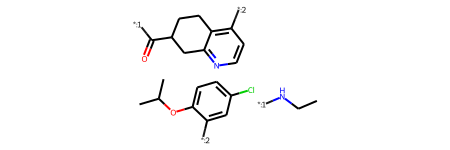

In [143]:
x = Chem.MolFromSmiles(frags_2[0])
x

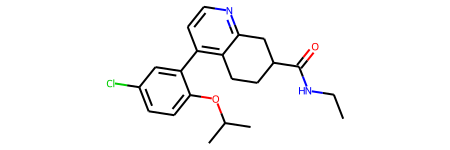

In [144]:
y = Chem.molzip(x)
y

Zip all the combinations

*If it cannot assemble the molecule it just returns the fragments and gives an rdkit warning*

In [145]:
mols = []
for i in frags_2:
    x = Chem.MolFromSmiles(i)
    y = Chem.molzip(x)
    z = Chem.MolToSmiles(y)
    mols.append(z)

print('Number of combinations assembled:',len(mols))

Number of combinations assembled: 150


In [146]:
mols = pd.DataFrame({'fragments': frags_2,'molecules': mols})

grid = mols2grid.MolGrid(mols, smiles_col="molecules", size=(200, 200), name="something")
grid.display(subset=["molecules","img"], n_cols=4)

In [ ]:
mols.to_excel('assembled_compounds.xlsx', index = True)

# Calculate mordred descriptors

Create rdmol objects and drop duplicates based on inchi

In [101]:
mols['rdmol'] = mols['molecules'].map(lambda x: Chem.MolFromSmiles(x))
mols['inchi'] = mols['rdmol'].map(Chem.MolToInchi)
mols = mols.drop_duplicates(subset="inchi")
mols

RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitted undefined stereo
RDKit WARNING: [06:39:45] WARNING: Omitt

,fragments,molecules,rdmol,inchi
0,CC(C)Oc1ccc(Cl)cc1[*:2].O=C(C1CCc2c([*:2])ccnc...,CCNC(=O)C1CCc2c(-c3cc(Cl)ccc3OC(C)C)ccnc2C1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C21H25ClN2O2/c1-4-23-21(25)14-5-7-17-...
1,CC(C)Oc1ccc(Cl)cc1[*:2].O=C(C1CCc2c([*:2])ccnc...,CC(C)CNC(=O)C1CCc2c(-c3cc(Cl)ccc3OC(C)C)ccnc2C1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C23H29ClN2O2/c1-14(2)13-26-23(27)16-5...
2,CC(C)Oc1ccc(Cl)cc1[*:2].O=C(C1CCc2c([*:2])ccnc...,CC(C)Oc1ccc(Cl)cc1-c1ccnc2c1CCC(C(=O)NCC(C)c1c...,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C28H31ClN2O2/c1-18(2)33-27-12-10-22(2...
3,CC(C)Oc1ccc(Cl)cc1[*:2].O=C(C1CCc2c([*:2])ccnc...,CC(C)Oc1ccc(Cl)cc1-c1ccnc2c1CCC(C(=O)NCC(C1=CC...,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C32H33ClN2O2/c1-21(2)37-31-15-13-25(3...
4,CC(C)Oc1ccc(Cl)cc1[*:2].O=C(C1CCc2c([*:2])ccnc...,COc1ccc(C(CNC(=O)C2CCc3c(-c4cc(Cl)ccc4OC(C)C)c...,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C33H35ClN2O3/c1-21(2)39-32-15-11-25(3...
...,...,...,...,...
145,CCOc1ncccc1[*:2].O=C(C1CCc2c([*:2])ccnc2C1)[*:...,CCOc1ncccc1-c1ccnc2c1CCC(C(=O)N(C)CC)C2,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C20H25N3O2/c1-4-23(3)20(24)14-8-9-16-...
146,CCOc1ncccc1[*:2].O=C(C1CCc2c([*:2])ccnc2C1)[*:...,CCOc1ncccc1-c1ccnc2c1CCC(C(=O)N(CC)CC1CC1)C2,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C23H29N3O2/c1-3-26(15-16-7-8-16)23(27...
147,CCOc1ncccc1[*:2].O=C(C1CCc2c([*:2])ccnc2C1)[*:...,CCOc1ncccc1-c1ccnc2c1CCC(C(=O)N(Cc1cccs1)CC1CC...,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C26H29N3O2S/c1-2-31-25-23(6-3-12-28-2...
148,CCOc1ncccc1[*:2].O=C(C1CCc2c([*:2])ccnc2C1)[*:...,CCOc1ncccc1-c1ccnc2c1CCC(C(=O)N(CC1CCC1)CC1CC1)C2,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C26H33N3O2/c1-2-31-25-23(7-4-13-28-25...


Force field optimization

In [102]:
def embed(mol):
    mol_with_H = Chem.AddHs(mol)
    Chem.AllChem.EmbedMolecule(mol_with_H)
    Chem.AllChem.MMFFOptimizeMolecule(mol_with_H)
    return mol_with_H

mols['rdmol_optimized'] = mols.rdmol.map(embed)

mols

,fragments,molecules,rdmol,inchi,rdmol_optimized
0,CC(C)Oc1ccc(Cl)cc1[*:2].O=C(C1CCc2c([*:2])ccnc...,CCNC(=O)C1CCc2c(-c3cc(Cl)ccc3OC(C)C)ccnc2C1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C21H25ClN2O2/c1-4-23-21(25)14-5-7-17-...,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,CC(C)Oc1ccc(Cl)cc1[*:2].O=C(C1CCc2c([*:2])ccnc...,CC(C)CNC(=O)C1CCc2c(-c3cc(Cl)ccc3OC(C)C)ccnc2C1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C23H29ClN2O2/c1-14(2)13-26-23(27)16-5...,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,CC(C)Oc1ccc(Cl)cc1[*:2].O=C(C1CCc2c([*:2])ccnc...,CC(C)Oc1ccc(Cl)cc1-c1ccnc2c1CCC(C(=O)NCC(C)c1c...,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C28H31ClN2O2/c1-18(2)33-27-12-10-22(2...,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,CC(C)Oc1ccc(Cl)cc1[*:2].O=C(C1CCc2c([*:2])ccnc...,CC(C)Oc1ccc(Cl)cc1-c1ccnc2c1CCC(C(=O)NCC(C1=CC...,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C32H33ClN2O2/c1-21(2)37-31-15-13-25(3...,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,CC(C)Oc1ccc(Cl)cc1[*:2].O=C(C1CCc2c([*:2])ccnc...,COc1ccc(C(CNC(=O)C2CCc3c(-c4cc(Cl)ccc4OC(C)C)c...,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C33H35ClN2O3/c1-21(2)39-32-15-11-25(3...,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...,...
145,CCOc1ncccc1[*:2].O=C(C1CCc2c([*:2])ccnc2C1)[*:...,CCOc1ncccc1-c1ccnc2c1CCC(C(=O)N(C)CC)C2,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C20H25N3O2/c1-4-23(3)20(24)14-8-9-16-...,"<img data-content=""rdkit/molecule"" src=""data:i..."
146,CCOc1ncccc1[*:2].O=C(C1CCc2c([*:2])ccnc2C1)[*:...,CCOc1ncccc1-c1ccnc2c1CCC(C(=O)N(CC)CC1CC1)C2,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C23H29N3O2/c1-3-26(15-16-7-8-16)23(27...,"<img data-content=""rdkit/molecule"" src=""data:i..."
147,CCOc1ncccc1[*:2].O=C(C1CCc2c([*:2])ccnc2C1)[*:...,CCOc1ncccc1-c1ccnc2c1CCC(C(=O)N(Cc1cccs1)CC1CC...,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C26H29N3O2S/c1-2-31-25-23(6-3-12-28-2...,"<img data-content=""rdkit/molecule"" src=""data:i..."
148,CCOc1ncccc1[*:2].O=C(C1CCc2c([*:2])ccnc2C1)[*:...,CCOc1ncccc1-c1ccnc2c1CCC(C(=O)N(CC1CCC1)CC1CC1)C2,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C26H33N3O2/c1-2-31-25-23(7-4-13-28-25...,"<img data-content=""rdkit/molecule"" src=""data:i..."


Calculate all mordred descriptors (can also specify subtype)

In [106]:
calc = Calculator(descriptors)

df = calc.pandas(mols['rdmol_optimized'])
df

100%|██████████| 150/150 [01:20<00:00,  1.85it/s]


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,20.034348,15.836207,0,0,33.170394,2.468501,4.937002,33.170394,1.275784,4.179241,...,10.184787,60.976891,372.160456,7.297264,1663,42,134.0,157.0,9.000000,5.805556
1,21.667342,16.828155,0,0,35.441008,2.468756,4.937511,35.441008,1.265750,4.249615,...,10.223431,63.269878,400.191756,7.020908,2115,44,144.0,167.0,10.111111,6.138889
2,25.760152,18.950169,0,0,43.081244,2.468986,4.937971,43.081244,1.305492,4.421508,...,10.393692,69.152661,462.207406,7.221991,3520,53,172.0,201.0,10.472222,7.250000
3,29.145856,21.630242,0,0,48.761891,2.469556,4.938883,48.761891,1.317889,4.545082,...,10.525219,86.936461,512.223056,7.317472,4711,59,196.0,231.0,10.583333,8.111111
4,30.560070,22.442837,0,0,51.201613,2.469633,4.939014,51.201613,1.312862,4.594620,...,10.577630,89.191307,542.233621,7.327481,5509,63,206.0,243.0,11.694444,8.611111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,19.068022,15.258645,0,0,32.803444,2.462680,4.925359,32.803444,1.312138,4.140636,...,10.156772,59.793654,339.194677,6.783894,1506,42,128.0,152.0,8.138889,5.750000
146,21.787059,16.938620,0,0,37.299065,2.466384,4.930551,37.299065,1.332109,4.287564,...,10.304041,81.700103,379.225977,6.653087,2102,46,148.0,177.0,8.000000,6.333333
147,25.322593,19.379892,0,0,42.804776,2.468584,4.933804,42.804776,1.337649,4.427415,...,10.411599,87.256753,447.198048,7.331116,3043,50,172.0,205.0,8.111111,7.083333
148,24.615486,18.817661,0,0,40.954005,2.469060,4.935200,40.954005,1.321097,4.403786,...,10.463132,85.471061,419.257277,6.550895,2791,49,168.0,201.0,7.861111,6.833333


Replace mordred errors with NaNs then drop those descriptors/columns

In [107]:
df=df.applymap(lambda x: np.nan if type(x) in [mordred.error.Missing,mordred.error.Error] else x)
df=df.dropna(axis=1)
print(df.shape)

(150, 1652)


Drop columns that have a single value

In [108]:
non_zero_std = df.std() != 0
df = df [non_zero_std[non_zero_std].index]
print(df.shape)

(150, 1403)


Drop highly correlated descriptors: If a pair of descriptors have a Pearson correlation coefficient (r) value greater than the threshold then one descriptor will be removed.

In [109]:
threshold=0.95
df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df = df.drop(to_drop, axis=1)
print(df.shape)

(150, 541)


Save the excel

In [ ]:
to_save=pd.concat([mols[['molecules']], df], axis=1)
to_save

In [ ]:
to_save.to_excel('mordred_descriptors.xlsx', index = True)

# PCA and K-means clustering

Test the descriptors. If an error due to NaN arises, go to bottom section.

In [110]:
df.index = df.index.astype(int)
df.dropna(axis=0,inplace=True)
X_all = np.array(df)
X_all_ids = np.array(df.index)
scaler = StandardScaler()
scaler.fit(X_all)
X_all_sc = scaler.transform(X_all)

pca = PCA(n_components=10)     # choose number of PCs

pca.fit(X_all_sc)
X_all_pca    = pca.transform(X_all_sc)
pca_score = pca.explained_variance_ratio_
pca_values = pca.singular_values_
print('Variance explained by individual PCs:',np.around(pca.explained_variance_ratio_, decimals=2),'\n')
print('Total variance explained by PCs:',np.around(np.sum(pca.explained_variance_ratio_), decimals=2))

Variance explained by individual PCs: [0.23 0.19 0.1  0.07 0.06 0.05 0.04 0.03 0.03 0.02] 

Total variance explained by PCs: 0.83


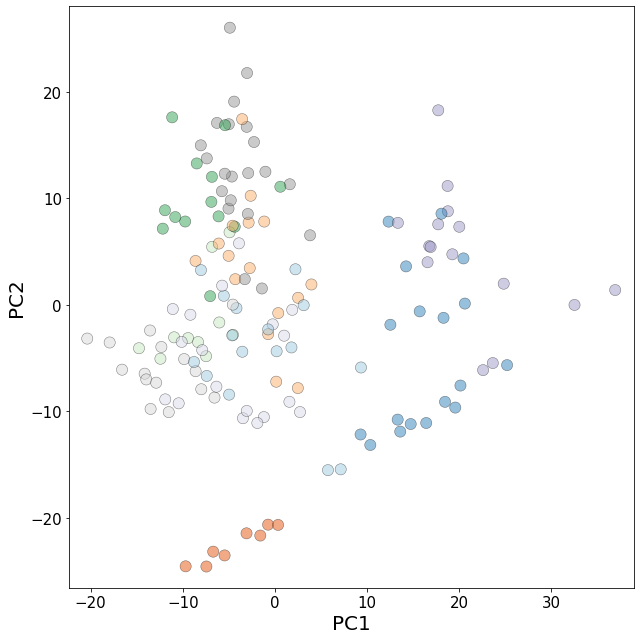

In [111]:
nclusters = 10     # choose number of clusters

####################################################################################

X_use = X_all_pca
X_main_ids = X_all_ids
X_kmeans = X_all_pca
kmeans = KMeans(n_clusters=nclusters, random_state=42).fit(X_kmeans)
dists = []
for x in range(len(X_kmeans)):
    delta = [X_kmeans[x,i]-kmeans.cluster_centers_[kmeans.labels_[x],i] for i in range(len(X_kmeans[0]))]
    dist = np.linalg.norm(delta)
    dists.append(dist)
clusters = {}
clusterdists = {}
clustermins = []
clusterorders_dict = {}
clusterorders = np.zeros(X_kmeans.shape[0])
for x in range(nclusters):
    clusters[x] = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == x]
    clusterdists[x] = [dists[i] for i in clusters[x]]
    clustermins.append(clusters[x][clusterdists[x].index(min(clusterdists[x]))])
    clusterorders_dict[x] = [y for _,y in sorted(zip(clusterdists[x],clusters[x]))]
    for i in clusters[x]:
        clusterorders[i] = clusterorders_dict[x].index(i)+1
f_ind_1 = 0
f_ind_2 = 1
x_min, x_max = X_kmeans[:, f_ind_1].min() - 2, X_kmeans[:, f_ind_1].max() + 2
y_min, y_max = X_kmeans[:, f_ind_2].min() - 2, X_kmeans[:, f_ind_2].max() + 2
plt.figure(figsize=(9,9))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.xlabel(r"PC1",fontsize=20)
plt.ylabel(r"PC2",fontsize=20)
plt.locator_params(axis='y', nbins=8)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
mapping = kmeans.labels_
cMap = "tab20c"
plt.scatter(X_kmeans[:,f_ind_1], X_kmeans[:,f_ind_2],c=mapping,cmap=cMap,alpha=.5,marker=".",s=500,edgecolor="black",linewidth=0.5)
main_row_id = list(enumerate(X_main_ids))
clusters_with_ids = {}
for i in range(0,len(clusters)):
    emptylist = []
    for j in range(0,len(clusters[i])):
        emptylist.append(main_row_id[clusters[i][j]][1])
    clusters_with_ids[i] = emptylist
    
### plot ligand ids    
#for i in range(0,nclusters):
#    for j in range(0,len(clusters_with_ids[i])):
#        plt.text(X_use[clusters[i][j],f_ind_1],X_use[clusters[i][j],f_ind_2]," "+str(clusters_with_ids[i][j]),color="blue",fontsize=12,ha="left")

### plot centroid labels
#for i in range(0,nclusters):
#    for j in range(0,len(clusters_with_ids[i])):
#        if clusters[i][j] in clustermins:
#            plt.text(X_use[clusters[i][j],f_ind_1],X_use[clusters[i][j],f_ind_2]," "+str(clusters_with_ids[i][j]),color="red",fontsize=13,ha="right")
    
plt.tight_layout()
#plt.savefig("mordred_pca_plot.png",dpi=300)
plt.show()     

RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitted undefined stereo
RDKit WARNING: [06:42:06] WARNING: Omitt

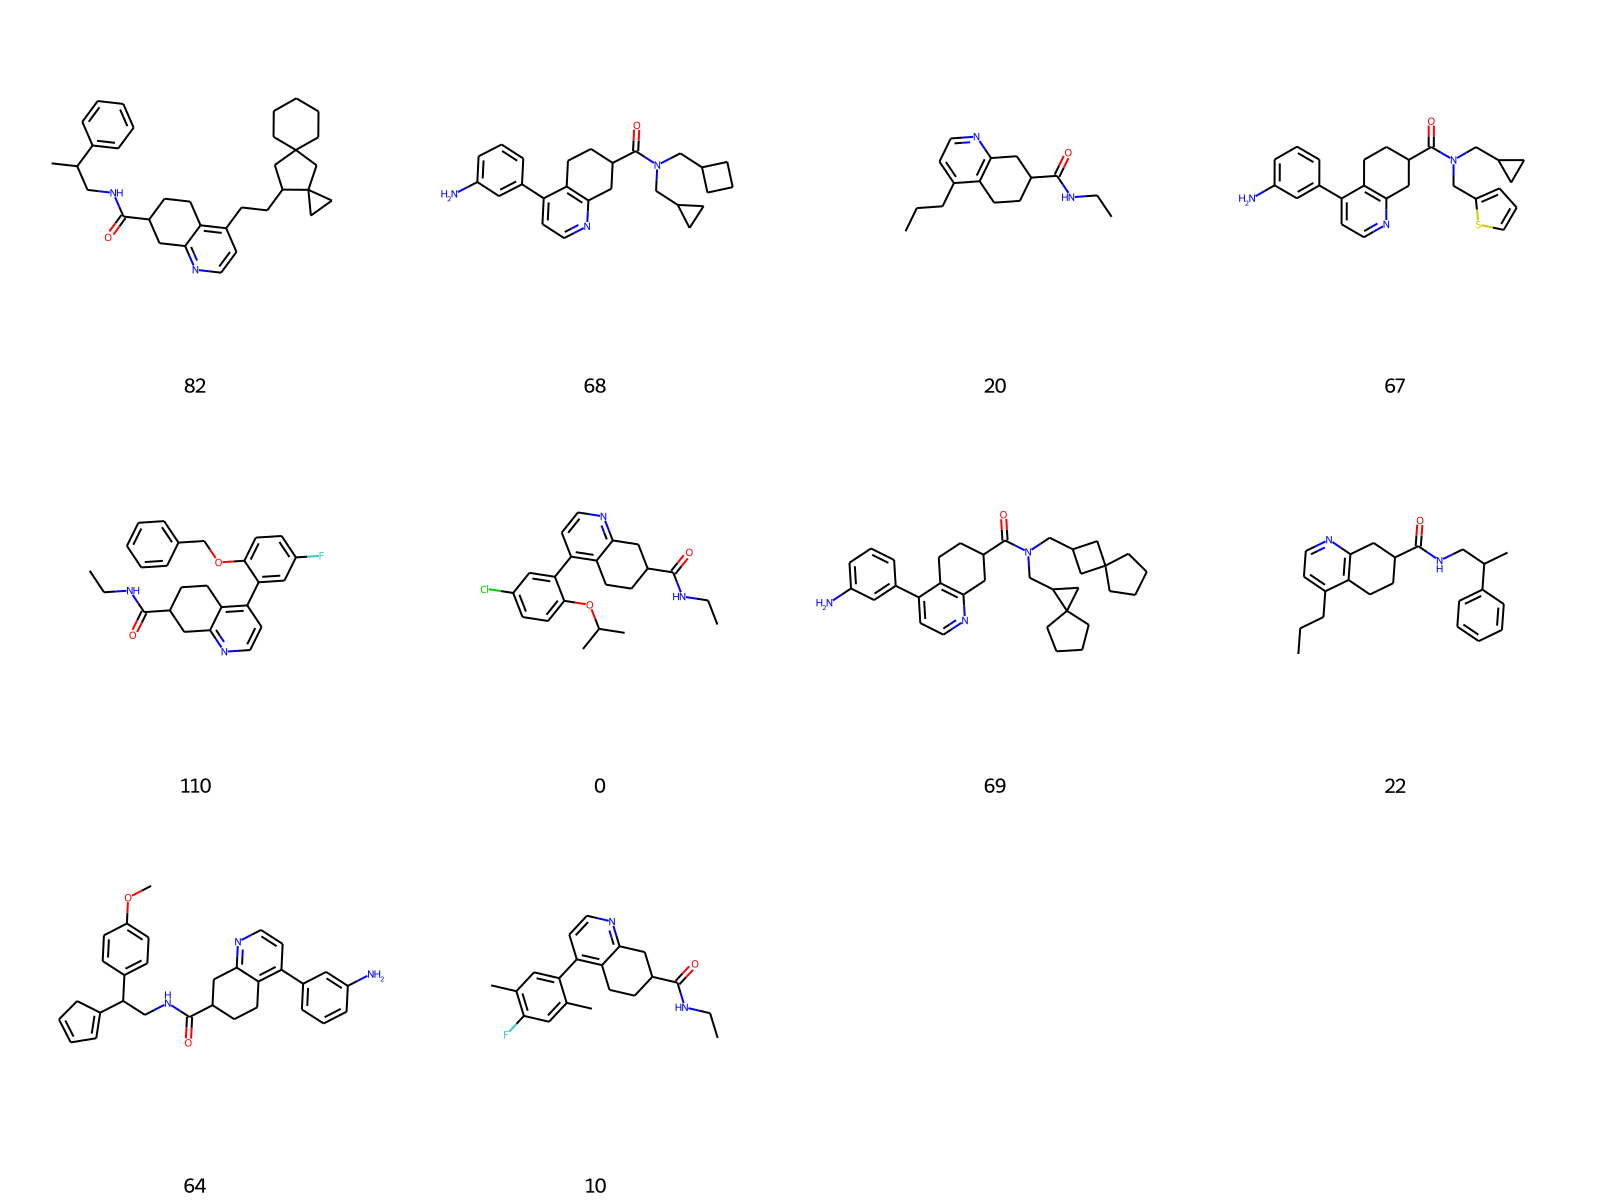

In [113]:
smiles = list(mols['molecules'])

closest_to_centroids = []
for i in clustermins:
    closest_to_centroids.append(smiles[i])

count=0
subms = []
for i in closest_to_centroids:
    x = Chem.MolFromSmiles(i)
    count+=1
    subms.append(x)
clustermins_str = [str(i) for i in clustermins]
my_labels = clustermins_str  
molsPerRow = 4
subImgSize= (400,400)
nRows = -(count // -molsPerRow)
fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
img = rdMolDraw2D.MolDraw2DCairo(fullSize[0],fullSize[1],subImgSize[0], subImgSize[1]) # setting up the image
img.drawOptions().legendFontSize=20
img.DrawMolecules(subms[:],legends=my_labels[:])
img.SetFontSize(100)
img.FinishDrawing()

with open('centroids.png','wb+') as wfp:      # opening a png file, goes into current folder
    wfp.write(img.GetDrawingText())           # saving in the image
Image.open('centroids.png')                   # opening it in the notebook

#  Finding other NaNs in X_all_sc

Find descriptors with bad sample values

In [ ]:
for i in range(0,len(X_all_sc)):
    if np.isnan(X_all_sc[i]).any():
        for j in range(0,len(X_all_sc[i])):
            if np.isnan(X_all_sc[i][j]):
                print('sample',i,'contains NaN for descriptor',j)

Find samples with bad descriptor values

In [ ]:
problem_samples = []
for i in range(0,len(X_all_sc)):
    if np.isnan(X_all_sc[i]).any():
        for j in range(0,len(X_all_sc[i])):
            if np.isnan(X_all_sc[i][j]):
                problem_samples.append(i)
                #print('sample',i,'contains NaN for descriptor',j)
unique_problem_samples = []
for i in problem_samples:
    if i not in unique_problem_samples:
        unique_problem_samples.append(i)
    else:
        pass
print("Problematic samples that will be removed are: " + str(unique_problem_samples))
df_with_deleted_rows = df2.drop(unique_problem_samples)
df_with_deleted_rows.to_excel(r'arylboronicacid_desc_test.xlsx', index = True)
#The above code gives a new excel sheet with molecules with NaNs removed.
print(problem_samples)

Produce a new excel sheet with all the smiles strings corresponding to molecules with NaNs removed.

In [ ]:
trimmed_smiles = []
for i in range(len(smiles)):
    if i not in unique_problem_samples:
        trimmed_smiles.append(smiles[i])
        print(smiles[i])
        #The printed smiles strings can be copied into excel directly
    else:
        pass

print("unaltered smiles list was ", len(smiles), " entries long.")
print("altered smiles list was ", len(trimmed_smiles), " entries long.")

